## Week 4 Peer Review Project:  Kaggle Competition: BBC News Classification 

##### Part 1:

For this week’s mini-project, you will participate in this Kaggle competition:  

Kaggle Competition: BBC News Classification 
 [80 pts]

This Kaggle competition is about categorizing news articles. You will use matrix factorization to predict the category and submit your notebook for peer evaluation. 

The part has 80 points. The instructions summarize the criteria you will use to guide your submission and review others’ submissions. 

You will submit one deliverable for Part 1: 

A Jupyter notebook with exploratory data analysis (EDA) procedure, model building and training, and comparison with supervised learning. 

Suppose your work becomes so large that it doesn’t fit into one notebook (or you think it will be less readable by having one large notebook). In that case, you can make several notebooks or scripts in a GitHub repository (as deliverable 3) and submit a report-style notebook or pdf instead.

##### Part 2:

Limitation(s) of sklearn’s non-negative matrix factorization library. [20 pts]

1. Load the movie ratings data (as in the HW3-recommender-system) and use matrix factorization technique(s) and predict the missing ratings from the test data. Measure the RMSE. You should use sklearn library. [10 pts]


2. Discuss the results and why sklearn's non-negative matrix facorization library did not work well compared to simple baseline or similarity-based methods we’ve done in Module 3. Can you suggest a way(s) to fix it? [10 pts]


references:

https://medium.com/logicai/non-negative-matrix-factorization-for-recommendation-systems-985ca8d5c16c

https://pub.towardsai.net/topic-modeling-with-nmf-for-user-reviews-classification-65913d0b44fe

https://chat.openai.com/share/532e586a-1268-4bae-aaf1-3182426380d2

#### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

from nltk.stem.porter import PorterStemmer
from numba import jit
from nltk.corpus import stopwords
import numpy as np

import nltk
import re
import string


In [2]:
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.decomposition import NMF

### Part 1. 

#### Instructions:  Step 1
Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Please feel free to look at online resources on processing raw texts to feature vectors. Many methods process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a method and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words. Also, do exploratory data analysis such as word statistics and/or visualization.

As we did not learn natural language processing (NLP) specific techniques such as word embeddings in the lectures, we recommend reading discussions and example codes from others in the Kaggle and/or doing some research online to make sure you understand. You can refer to any resource as needed, but make sure you “demonstrate” your understanding- please include explaining in your own words, discussions, and your interpretation. Also importantly, please have a reference list at the end of the report. 


##### Read Files and perform initial visual inspection of data

In [3]:
path = '/Users/ayeshamendoza/UCB/5510 - Unsupervised Learning/data'

files = glob.glob(os.path.join(path, "*.csv"))

In [4]:
files

['/Users/ayeshamendoza/UCB/5510 - Unsupervised Learning/data/BBC News Train.csv',
 '/Users/ayeshamendoza/UCB/5510 - Unsupervised Learning/data/BBC News Test.csv',
 '/Users/ayeshamendoza/UCB/5510 - Unsupervised Learning/data/BBC News Sample Solution.csv']

In [5]:
sample_df = pd.read_csv(files[2])

In [6]:
train_df = pd.read_csv(files[0])

Make sure all our rows are labeled.  It looks like all our training data are set to one of the 5 categories


In [7]:
# Check for nulls in the dataframe
train_df.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [8]:
train_df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [9]:
test_df = pd.read_csv(files[1])
test_df.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


### Data Validation

##### The following validations were done:
- vaidate that article is assigned to one or more category to determine if it is a multi-class classification or a multi-label classification.

- Inspect the number of rows for each category to determine if we have imbalanced data, so we can handle if needed.
- Inspect for missing or null values, to make sure every article in Training dataset has a label, and that the `Text` column is not nulls.

Check if an article is assigned to more than one category
- It looks good, all articles are just assigned to one category

In [10]:
article_counts = train_df['ArticleId'].value_counts()

# Check for multiple rows for an ArticleID
duplicate_article_ids = article_counts[article_counts > 1].index
duplicate_article_ids

Int64Index([], dtype='int64')

In [11]:
train_df.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

##### Inspect how many rows we have for each category, and determine if we have imbalanced data.

It looks like we have pretty good distribution of samples for each category.

In [12]:
article_counts = train_df['ArticleId'].value_counts()

# Filter to find ArticleIds with more than one occurrence
more_than_one = article_counts[article_counts > 1]

# Show the ArticleIds that have more than one occurrence
print(more_than_one)

repeated_articles = train_df[train_df['ArticleId'].isin(more_than_one.index)]
print(repeated_articles)

Series([], Name: ArticleId, dtype: int64)
Empty DataFrame
Columns: [ArticleId, Text, Category]
Index: []


View Distribution of data to verify if we have an imbalanced dataset.

- The different categories seems to be well distributed, no class has a significantly low number of samples

<AxesSubplot: xlabel='Category', ylabel='count'>

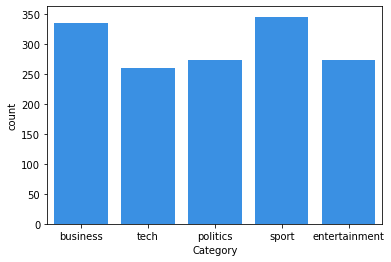

In [13]:
sns.countplot(x='Category', data=train_df, color='dodgerblue')

### Text data Pre-processing

The following pre-processing steps were done with the text data:
- Tokenization: breaks the down the text into tokens
- Stemming, Lemmatization: removes redundancy in words by finding the root form by removing affixes from inflected word forms
- Remove punctuation, numbers and stopwords: stopwords are the most common words in the language but are not important in deriving the meaning, these are words such as 'a', 'but', they', etc.  Stop words can be customizable depending on the industry you are working on, i.e. if you are working for a bank, the word 'bank' might appear frequently in the documents and might not be relevant in analyzing documents.

In [14]:
# Testing tokenization on sample Text

# tokenize and print tokens from the sample Text
sample_tokens = nltk.word_tokenize(train_df.iloc[0]['Text'])
print(sample_tokens,'\n')

['worldcom', 'ex-boss', 'launches', 'defence', 'lawyers', 'defending', 'former', 'worldcom', 'chief', 'bernie', 'ebbers', 'against', 'a', 'battery', 'of', 'fraud', 'charges', 'have', 'called', 'a', 'company', 'whistleblower', 'as', 'their', 'first', 'witness', '.', 'cynthia', 'cooper', 'worldcom', 's', 'ex-head', 'of', 'internal', 'accounting', 'alerted', 'directors', 'to', 'irregular', 'accounting', 'practices', 'at', 'the', 'us', 'telecoms', 'giant', 'in', '2002.', 'her', 'warnings', 'led', 'to', 'the', 'collapse', 'of', 'the', 'firm', 'following', 'the', 'discovery', 'of', 'an', '$', '11bn', '(', '£5.7bn', ')', 'accounting', 'fraud', '.', 'mr', 'ebbers', 'has', 'pleaded', 'not', 'guilty', 'to', 'charges', 'of', 'fraud', 'and', 'conspiracy', '.', 'prosecution', 'lawyers', 'have', 'argued', 'that', 'mr', 'ebbers', 'orchestrated', 'a', 'series', 'of', 'accounting', 'tricks', 'at', 'worldcom', 'ordering', 'employees', 'to', 'hide', 'expenses', 'and', 'inflate', 'revenues', 'to', 'meet',

#### Set-up Stemmer, translator

In [15]:
translator = str.maketrans(string.punctuation, ' '*32)
porterStemmer = PorterStemmer()

# get list of lemmatized/stemmed tokens
def stemTokenList(tokens, stemmer):
    return [stemmer.stem(token) for token in tokens]

# get out stemmed tokens from text
def noPunctWordTokenizerStemmer(text, stemmer=porterStemmer):
    # basic tokens to feed to our stem tokenizer
    tokens = nltk.word_tokenize(text.translate(translator))
    # stem
    stemmed_tokens = stemTokenList(tokens, stemmer)
    return stemmed_tokens

def cleanText(text, stemmer=porterStemmer):
    # basic tokens to feed to our stem tokenizer
    stopwords_english = stopwords.words('english')
    
    tokens = nltk.word_tokenize(text.translate(translator))
    
    filtered_tokens = [token for token in tokens if not token.isdigit()]
    filtered_tokens = [token for token in filtered_tokens if token not in stopwords_english]
    
    # stem
    stemmed_tokens = stemTokenList(filtered_tokens, stemmer)
    text = ' '.join(stemmed_tokens)
    return text


In [16]:
# Save cleaned tokens
train_df['cleaned_tokens'] = train_df['Text'].apply(lambda x: cleanText(x))

In [17]:
word_count_dict = {}

for ix, row in train_df.iterrows():
    for word in row['cleaned_tokens'].split(" "):
        if word in word_count_dict:
            word_count_dict[word] += 1
        else:
            word_count_dict[word] = 1

In [18]:
sorted_dict = dict(sorted(word_count_dict.items(), key=lambda item: item[1], reverse=True))

<AxesSubplot: title={'center': 'Top 20 most frequent words used'}>

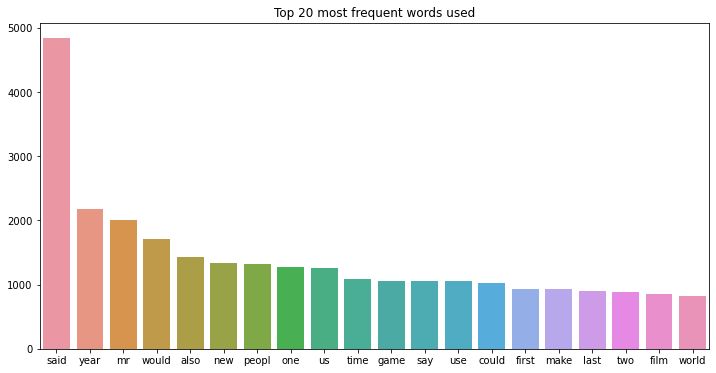

In [19]:
plt.figure(figsize=(12,6))
plt.title("Top 20 most frequent words used")
sns.barplot(x=list(sorted_dict.keys())[:20], y=list(sorted_dict.values())[:20])

### Feature extraction:

For feature processing, I used TF-IDF for this iteration.

`TF-IDF` is a technique that assesses the importance of words relative to a collection of documents

`TF`: is the frequency of any term in the document

`IDF`: accounts for the ratio of the documents that include that specific 'term'

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train_df['cleaned_tokens'],
                                                    train_df['Category'], test_size=0.2, random_state=42)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

# create the transformer

tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True, sublinear_tf=True)

# features_tfidf = tfidf.fit_transform(features_counts) # For transformer
features_tfidf = tfidf.fit_transform(X_train.values)

print("TF-IDF matrix of %d articles with %d feature tokens" % features_tfidf.shape)

TF-IDF matrix of 1192 articles with 15285 feature tokens


In [22]:
# Run NMF using tf-idf features
beta_loss_params = {'frobenius':'cd', 'kullback-leibler':'mu'}
l1_ratio_params = [0.0, 1.0]

# Initialize nmf_score dict to keep track of train scores for nmf
nmf_score = {}
# num_categories were set to 5 since there are 5 categories to classify
num_categories = 5
random_state = 42


for loss_param, solver in beta_loss_params.items():
    nmfs = []
    for l1_param in l1_ratio_params:
        param_dict = {}
        nmf = NMF(n_components=num_categories,
                  random_state=random_state,
                  solver=solver,
                  beta_loss=loss_param,
                  l1_ratio = l1_param)
        nmf.fit(features_tfidf)
        param_dict['l1'] = l1_param
        param_dict['nmf_fit'] = nmf
        nmfs.append(param_dict)
        
    nmf_score[loss_param] = nmfs

In [23]:
nmf_score

{'frobenius': [{'l1': 0.0, 'nmf_fit': NMF(n_components=5, random_state=42)},
  {'l1': 1.0, 'nmf_fit': NMF(l1_ratio=1.0, n_components=5, random_state=42)}],
 'kullback-leibler': [{'l1': 0.0,
   'nmf_fit': NMF(beta_loss='kullback-leibler', n_components=5, random_state=42, solver='mu')},
  {'l1': 1.0,
   'nmf_fit': NMF(beta_loss='kullback-leibler', l1_ratio=1.0, n_components=5, random_state=42,
       solver='mu')}]}

### Display top `n` words for the different categories identified

In [25]:
def display_top_words(feature_names, nmf, n_top_words=15):
    topic_dict = {}
    for i, topic_vec in enumerate(nmf.components_):
        topic_words = []
        for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
            topic_words.append(feature_names[fid])

            
        topic_dict[i] = topic_words
        
    return topic_dict

for loss_param, nmfs in nmf_score.items():
    for nmf_fitted in nmfs:
        topics = display_top_words(tfidf.get_feature_names(), nmf_fitted['nmf_fit'], n_top_words=15)
        print(f"\n {loss_param} , {nmf_fitted['l1']} ")
        for key, topic_words in topics.items():
            print(f"Topic {key} : {' '.join(topic_words)}")


 frobenius , 0.0 
Topic 0 : elect mr labour blair parti tori govern minist would prime said say leader plan tax
Topic 1 : game play win england match player team cup first final side champion back injuri coach
Topic 2 : use peopl mobil phone technolog user servic comput digit softwar net music said onlin video
Topic 3 : film award star best actor oscar nomin actress director comedi music aviat includ ceremoni year
Topic 4 : growth market economi said bank compani firm year econom us share rate sale price rise

 frobenius , 1.0 
Topic 0 : elect mr labour blair parti tori govern minist would prime said say leader plan tax
Topic 1 : game play win england match player team cup first final side champion back injuri coach
Topic 2 : use peopl mobil phone technolog user servic comput digit softwar net music said onlin video
Topic 3 : film award star best actor oscar nomin actress director comedi music aviat includ ceremoni year
Topic 4 : growth market economi said bank compani firm year econo

We can map labels based on the following topics found by NMF

In [26]:
label_to_num_map = {'tech':2, 'sport':1, 'politics':0, 'business':4, 'entertainment':3}

In [27]:
train_preds = pd.DataFrame({'tokens': X_train.values, 'actual_labels': y_train.values})
train_preds['actual_num_labels'] = train_preds['actual_labels'].map(label_to_num_map)

### Evaluate and Tune NMF models

- different beta_loss_params and l1_ratio were used, but as we will see in the results below that the `l1_ratio` did not contribute to any change in the scores, but for the `beta_loss` parameter, the accuracy is better with `beta_loss = 'frobenius'`

### Find Training accuracy for NMF (parameters: beta_loss_params = 'frobenius', l1_ratio = 1.0)

In [28]:
# Get NMF prediction for topics

for loss_param, nmfs in nmf_score.items():
    for nmf_fitted in nmfs:
        nmf = nmf_fitted['nmf_fit']
        train_pred = nmf.transform(features_tfidf)
        train_preds['pred_label'] = np.argmax(train_pred, axis=1)

        accuracy = accuracy_score(train_preds['actual_num_labels'], train_preds['pred_label'])
        print(f"NMF Training Accuracy : params = {loss_param}, {nmf_fitted['l1']} : {accuracy}")

NMF Training Accuracy : params = frobenius, 0.0 : 0.9404362416107382
NMF Training Accuracy : params = frobenius, 1.0 : 0.9404362416107382
NMF Training Accuracy : params = kullback-leibler, 0.0 : 0.9219798657718121
NMF Training Accuracy : params = kullback-leibler, 1.0 : 0.9219798657718121


## Process Test dataset

In [29]:
test_preds = pd.DataFrame({'tokens': X_test.values, 'actual_labels': y_test.values})
test_preds['actual_num_labels'] = test_preds['actual_labels'].map(label_to_num_map)

test_tfidf = tfidf.transform(X_test.values)


Evaluate different NMF's using Test data

In [30]:
for loss_param, nmfs in nmf_score.items():
    for nmf_fitted in nmfs:
        
        test_preds = pd.DataFrame({'tokens': X_test.values, 'actual_labels': y_test.values})
        test_preds['actual_num_labels'] = test_preds['actual_labels'].map(label_to_num_map)
        
        nmf = nmf_fitted['nmf_fit']
        test_pred = nmf.transform(test_tfidf)
        test_preds['pred_label'] = np.argmax(test_pred, axis=1)

        accuracy = accuracy_score(test_preds['actual_num_labels'], test_preds['pred_label'])
        print(f"NMF Test Accuracy : params = {loss_param}, {nmf_fitted['l1']} : {accuracy}")

NMF Test Accuracy : params = frobenius, 0.0 : 0.959731543624161
NMF Test Accuracy : params = frobenius, 1.0 : 0.959731543624161
NMF Test Accuracy : params = kullback-leibler, 0.0 : 0.9261744966442953
NMF Test Accuracy : params = kullback-leibler, 1.0 : 0.9261744966442953


### Display Accuracy and Classification Report for the best model

In [31]:
test_preds = pd.DataFrame({'tokens': X_test.values, 'actual_labels': y_test.values})
test_preds['actual_num_labels'] = test_preds['actual_labels'].map(label_to_num_map)

nmf = nmf_score['frobenius'][0]['nmf_fit']
test_pred = nmf.transform(test_tfidf)
test_preds['pred_label'] = np.argmax(test_pred, axis=1)
print("NMF Test set accuracy: {:.2f}".format(accuracy_score(test_preds['actual_num_labels'] , test_preds['pred_label'])))
print("NMF Classification report:\n", classification_report(test_preds['actual_num_labels'] , test_preds['pred_label']))


NMF Test set accuracy: 0.96
NMF Classification report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95        56
           1       0.97      1.00      0.98        63
           2       0.92      0.97      0.94        58
           3       1.00      0.91      0.95        46
           4       0.96      0.97      0.97        75

    accuracy                           0.96       298
   macro avg       0.96      0.96      0.96       298
weighted avg       0.96      0.96      0.96       298



#### Step 3. Compare with supervised learning [30 pts]

Use the following steps to guide your work:

1) Pick and train a supervised learning method(s) and compare the results (train and test performance)
2) Discuss comparison with the unsupervised approach. You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes). Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?



In [32]:
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(max_iter=200, random_state=42))
])

param_grid_lr = {
    'tfidf__max_df': [0.75, 1.0],
    'tfidf__min_df': [1, 2],
    'clf__C': [0.1, 1, 10]
}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search_lr.fit(X_train, y_train)

# Best parameters and best score for Logistic Regression
print("LR Best parameters found: ", grid_search_lr.best_params_)
print("LR Best cross-validation score: {:.2f}".format(grid_search_lr.best_score_))

# Predict on the test set with Logistic Regression
y_pred_lr = grid_search_lr.predict(X_test)

# Evaluate the Logistic Regression model
print("LR Test set accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_lr)))
print("LR Classification report:\n", classification_report(y_test, y_pred_lr))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   24.8s finished


LR Best parameters found:  {'clf__C': 10, 'tfidf__max_df': 1.0, 'tfidf__min_df': 1}
LR Best cross-validation score: 0.97
LR Test set accuracy: 0.97
LR Classification report:
                precision    recall  f1-score   support

     business       0.96      0.99      0.97        75
entertainment       0.96      1.00      0.98        46
     politics       0.96      0.93      0.95        56
        sport       0.98      1.00      0.99        63
         tech       1.00      0.95      0.97        58

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298



### Results Summary:

- After running the BBC News Classification dataset using NMF (Unsupervised technique), and using Logistic Regression for Supervised technique, the Supervised ML technique outperformed the NMF by .01.
Both models appear to perform well and generalized well with the test data -- no overfitting observed from the results yielded.

- NMF does the classification/grouping by uncovering hidden patterns/structure in the data, which appears to be in this case comparable to Logistic Regression which was used for the Supervised ML approach.  Logistic Regression / Supervised ML could provide more accurate results since Supervised ML models are trained to learn from the data. 

Additional tuning and cross-validation can be done using NMF, but due to time constraints, I am reporting the results generated from this iteration.